In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark as ps
import scipy.stats as stats

import sys
sys.path.append("..")
from src.support_functions import get_zip_income, fixing_datetime
plt.style.use('ggplot')

## Loading Datasets into Pandas DataFrames of COVID-19 numbers

In [2]:
data_by_zip = pd.read_csv('../data/data-by-modzcta.csv')

In [3]:
data_by_zip = data_by_zip.rename(columns={"MODIFIED_ZCTA": "Zip",
                            "NEIGHBORHOOD_NAME": "Neighborhood",
                            "BOROUGH_GROUP": "Borough",
                            "COVID_CASE_COUNT": "Covid_Case_Count",
                            "COVID_CASE_RATE": "Covid_Case_Rate",
                            "POP_DENOMINATOR": "Pop_Denominator",
                            "COVID_DEATH_COUNT": "Covid_Death_Count",
                            "COVID_DEATH_RATE":"Covid_Death_Rate",
                            "PERCENT_POSITIVE":"Percent_Positive",
                            "TOTAL_COVID_TESTS": "Total_Covid_Tests"})

In [4]:
tests_by_day = pd.read_csv('../data/tests.csv')

In [5]:
tests_by_day = tests_by_day.rename(columns={"DATE": "Date",
                             "TOTAL_TESTS": "Total_Tests",
                             "POSITIVE_TESTS": "Positive_Tests",
                             "PERCENT_POSITIVE": "Percent_Positive",
                             "TOTAL_TESTS_7DAYS_AVG": "Total_Tests_7Days_AVG",
                             "POSITIVE_TESTS_7DAYS_AVG": "Positive_Tests_7Days_AVG",
                             "PERCENT_POSITIVE_7DAYS_AVG": "Percent_Positive_7Days_AVG",
                             "INCOMPLETE": "Incomplete"})

In [6]:
tests_by_boro = pd.read_csv('../data/by-boro.csv')

In [7]:
tests_by_boro = tests_by_boro.rename(columns={"BOROUGH_GROUP": "Borough",
                             "CASE_RATE": "Case_Rate",
                             "HOSPITALIZED_RATE": "Hospitalized_Rate",
                             "DEATH_RATE": "Death_Rate",
                             "CASE_COUNT": "Case_Count",
                             "HOSPITALIZED_COUNT": "Hospitalized_Count",
                             "DEATH_COUNT": "Death_Count"})

In [8]:
median_income = get_zip_income()
med_income = median_income[['median_household_income', 'lat', 'lng', 'population', 'population_density']]
data = data_by_zip[['Zip', 'Neighborhood','Borough', 'Covid_Case_Count', 'Total_Covid_Tests', 'Covid_Death_Count']]
hm_covid = data.join(med_income)

In [9]:
hm_covid.head()

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,479,10193,28,81671,40.750,-73.990,21102,33959.0
1,10002,Chinatown/Lower East Side,Manhattan,1452,24932,160,33218,40.720,-73.990,81410,92573.0
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,701,25829,35,92540,40.730,-73.990,56024,97188.0
3,10004,Financial District,Manhattan,57,1350,1,129313,40.700,-74.020,3089,5519.0
4,10005,Financial District,Manhattan,120,3228,2,124670,40.705,-74.005,7135,97048.0


## Cleaning up Data for what I need

In [10]:
data_by_zip_test = data_by_zip.copy()

In [11]:
data_by_zip_test

,Zip,Neighborhood,Borough,Covid_Case_Count,Covid_Case_Rate,Pop_Denominator,Covid_Death_Count,Covid_Death_Rate,Percent_Positive,Total_Covid_Tests
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,479,2032.85,23563.03,28,118.83,4.70,10193
1,10002,Chinatown/Lower East Side,Manhattan,1452,1891.72,76755.41,160,208.45,5.82,24932
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,701,1302.93,53801.62,35,65.05,2.71,25829
3,10004,Financial District,Manhattan,57,1561.38,3650.61,1,27.39,4.22,1350
4,10005,Financial District,Manhattan,120,1429.23,8396.11,2,23.82,3.72,3228
...,...,...,...,...,...,...,...,...,...,...
172,11691,Edgemere/Far Rockaway,Queens,3136,4842.57,64759.02,379,585.25,13.64,22996
173,11692,Arverne/Edgemere,Queens,742,3687.83,20120.24,95,472.16,11.18,6635
174,11693,Arverne/Broad Channel,Queens,372,3004.54,12381.27,29,234.22,10.92,3408
175,11694,Belle Harbor-Neponsit/Rockaway Park,Queens,833,4092.20,20355.78,90,442.13,12.09,6892


In [12]:
#df['tier'] = np.select(conditions, values)
#df['hasimage'] = np.where(df['photos']!= '[]', True, False)

In [13]:
data_by_zip_test = data_by_zip_test.join(med_income)

In [14]:
#gb2019 = ts_df_2019[['Unit', 'SCP', 'Date', 'Entries']].groupby(['Date', 'Unit', 'SCP']).agg([min, max])
data_by_zip[['Borough', 'Covid_Case_Count']].groupby(['Borough']).agg([sum])

,Covid_Case_Count
,sum
Borough,
Bronx,54074
Brooklyn,69752
Manhattan,31817
Queens,73803
Staten Island,16467


In [15]:
data_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Zip                177 non-null    int64  
 1   Neighborhood       177 non-null    object 
 2   Borough            177 non-null    object 
 3   Covid_Case_Count   177 non-null    int64  
 4   Covid_Case_Rate    177 non-null    float64
 5   Pop_Denominator    177 non-null    float64
 6   Covid_Death_Count  177 non-null    int64  
 7   Covid_Death_Rate   177 non-null    float64
 8   Percent_Positive   177 non-null    float64
 9   Total_Covid_Tests  177 non-null    int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 14.0+ KB


In [16]:
tests_by_day.head(100)

,Date,Total_Tests,Positive_Tests,Percent_Positive,Total_Tests_7Days_AVG,Positive_Tests_7Days_AVG,Percent_Positive_7Days_AVG,Incomplete
0,03/03/2020,14,1,0.0714,NaN,NaN,NaN,NaN
1,03/04/2020,33,5,0.1515,NaN,NaN,NaN,NaN
2,03/05/2020,65,4,0.0615,NaN,NaN,NaN,NaN
3,03/06/2020,85,8,0.0941,NaN,NaN,NaN,NaN
4,03/07/2020,72,8,0.1111,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
95,06/06/2020,13211,374,0.0283,24178.0,740.0,0.031,NaN
96,06/07/2020,10724,329,0.0307,24221.0,731.0,0.030,NaN
97,06/08/2020,34549,793,0.0230,24506.0,690.0,0.028,NaN
98,06/09/2020,33708,685,0.0203,25120.0,656.0,0.026,NaN


In [17]:
tests_by_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        234 non-null    object 
 1   Total_Tests                 234 non-null    int64  
 2   Positive_Tests              234 non-null    int64  
 3   Percent_Positive            234 non-null    float64
 4   Total_Tests_7Days_AVG       228 non-null    float64
 5   Positive_Tests_7Days_AVG    228 non-null    float64
 6   Percent_Positive_7Days_AVG  228 non-null    float64
 7   Incomplete                  7 non-null      float64
dtypes: float64(5), int64(2), object(1)
memory usage: 14.8+ KB


In [18]:
# tests_by_day['DATE'] = pd.to_datetime(tests_by_day.DATE)
tests_by_day = fixing_datetime(tests_by_day)

In [19]:
tests_by_day.head(10)

,Date,Total_Tests,Positive_Tests,Percent_Positive,Total_Tests_7Days_AVG,Positive_Tests_7Days_AVG,Percent_Positive_7Days_AVG,Incomplete
0,2020-03-03,14,1,0.0714,NaN,NaN,NaN,NaN
1,2020-03-04,33,5,0.1515,NaN,NaN,NaN,NaN
2,2020-03-05,65,4,0.0615,NaN,NaN,NaN,NaN
3,2020-03-06,85,8,0.0941,NaN,NaN,NaN,NaN
4,2020-03-07,72,8,0.1111,NaN,NaN,NaN,NaN
5,2020-03-08,111,21,0.1892,NaN,NaN,NaN,NaN
6,2020-03-09,406,60,0.1478,112.0,15.0,0.136,NaN
7,2020-03-10,467,73,0.1563,177.0,26.0,0.144,NaN
8,2020-03-11,811,164,0.2022,288.0,48.0,0.168,NaN
9,2020-03-12,1611,369,0.2291,509.0,100.0,0.197,NaN


In [20]:
test_by_day = tests_by_day.copy()
#df1.cumsum(axis = 0)

In [21]:
test_by_day['Cum_Positive_Tests'] = test_by_day['Positive_Tests'].cumsum(axis=0)
test_by_day['Cum_Total_Tests'] = test_by_day['Total_Tests'].cumsum(axis=0)
test_by_day['Cum_Percent_Positive'] = test_by_day['Cum_Positive_Tests'] / test_by_day['Cum_Total_Tests']

In [22]:
test_by_day

,Date,Total_Tests,Positive_Tests,Percent_Positive,Total_Tests_7Days_AVG,Positive_Tests_7Days_AVG,Percent_Positive_7Days_AVG,Incomplete,Cum_Positive_Tests,Cum_Total_Tests,Cum_Percent_Positive
0,2020-03-03,14,1,0.0714,NaN,NaN,NaN,NaN,1,14,0.071429
1,2020-03-04,33,5,0.1515,NaN,NaN,NaN,NaN,6,47,0.127660
2,2020-03-05,65,4,0.0615,NaN,NaN,NaN,NaN,10,112,0.089286
3,2020-03-06,85,8,0.0941,NaN,NaN,NaN,NaN,18,197,0.091371
4,2020-03-07,72,8,0.1111,NaN,NaN,NaN,NaN,26,269,0.096654
...,...,...,...,...,...,...,...,...,...,...,...
207,2020-09-26,19336,337,0.0174,34221.0,500.0,0.015,NaN,286908,4343707,0.066051
208,2020-09-27,14620,460,0.0315,34516.0,537.0,0.016,NaN,287368,4358327,0.065935
209,2020-09-28,43851,541,0.0123,34591.0,521.0,0.015,NaN,287909,4402178,0.065401
210,2020-09-29,42695,816,0.0191,34849.0,566.0,0.016,NaN,288725,4444873,0.064957


## Plotting

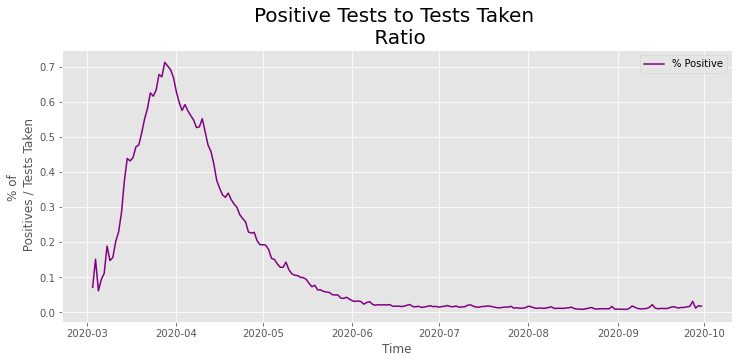

In [23]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(tests_by_day['Date'], tests_by_day['Percent_Positive'], color='Purple', label='% Positive')
ax.set_title('Positive Tests to Tests Taken \n Ratio', fontsize=20)
ax.set_ylabel('% of \n Positives / Tests Taken')
ax.set_xlabel('Time')
ax.legend()
plt.savefig('../img/Positive_Tests_to_Tests_Taken_Ratio',  dpi=60)

In [24]:
tests_by_boro.head(10)

,Borough,Case_Rate,Hospitalized_Rate,Death_Rate,Case_Count,Hospitalized_Count,Death_Count
0,Bronx,3834.00,898.59,283.07,54908,12869,4054
1,Brooklyn,2804.13,652.00,222.28,72426,16840,5741
2,Manhattan,2034.01,511.94,156.26,33128,8338,2545
3,Queens,3296.67,793.45,265.92,75128,18082,6060
4,StatenIsland,3488.60,536.77,190.89,16612,2556,909
5,Citywide,3003.79,698.85,229.96,252281,58695,19314


In [25]:
tests_by_boro['Death_Positive_Rate'] = tests_by_boro['Death_Count'] / tests_by_boro['Case_Count']

In [26]:
tests_by_boro['Death_Hospitalized_Rate'] = tests_by_boro['Death_Count'] / tests_by_boro['Hospitalized_Count']

In [27]:
# fig, axs = plt.subplots(2, 2)
# axs[0, 0].plot(x, y)
# axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

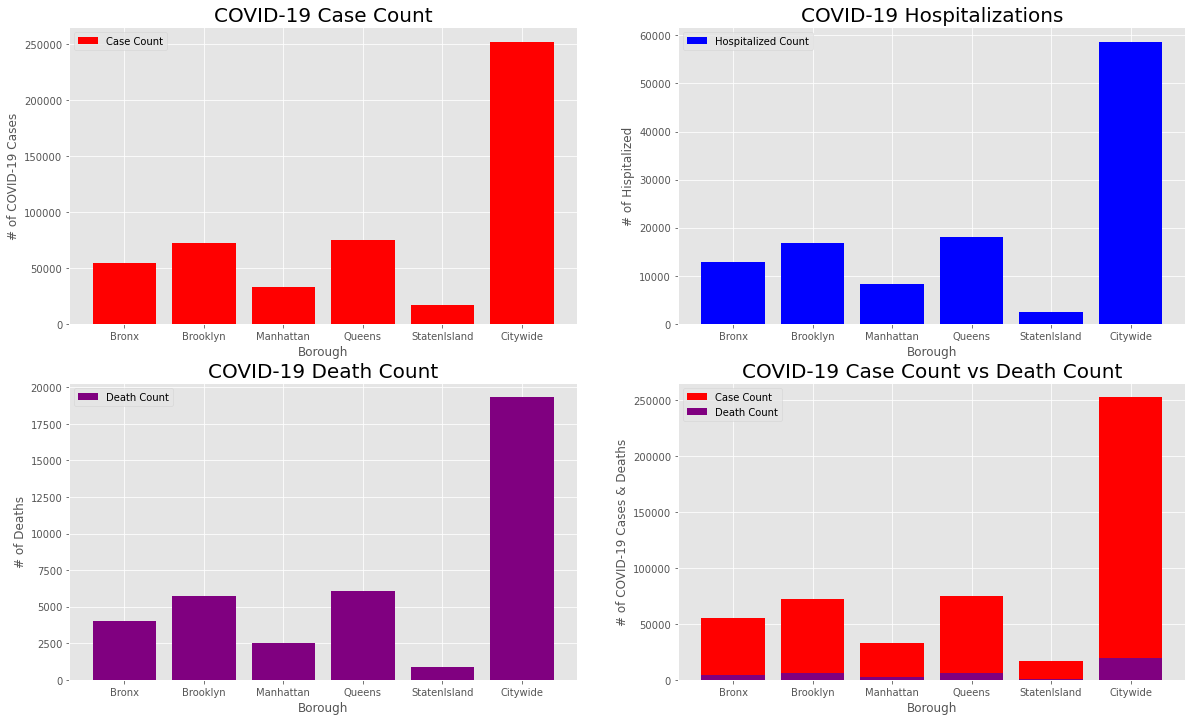

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(20,12))

axs[0,0].bar(tests_by_boro['Borough'], tests_by_boro['Case_Count'], color='red', label='Case Count')
axs[0,0].set_title('COVID-19 Case Count', fontsize=20)
axs[0,0].set_xlabel('Borough')
axs[0,0].set_ylabel('# of COVID-19 Cases')
axs[0,0].legend()

axs[0,1].bar(tests_by_boro['Borough'], tests_by_boro['Hospitalized_Count'], color='blue', label='Hospitalized Count')
axs[0,1].set_title('COVID-19 Hospitalizations', fontsize=20)
axs[0,1].set_xlabel('Borough')
axs[0,1].set_ylabel('# of Hispitalized')
axs[0,1].legend()

axs[1,0].bar(tests_by_boro['Borough'], tests_by_boro['Death_Count'], color='purple', label='Death Count')
axs[1,0].set_title('COVID-19 Death Count', fontsize=20)
axs[1,0].set_xlabel('Borough')
axs[1,0].set_ylabel('# of Deaths')
axs[1,0].legend()

axs[1,1].bar(tests_by_boro['Borough'], tests_by_boro['Case_Count'], color='red', label='Case Count')
axs[1,1].legend()
axs[1,1].bar(tests_by_boro['Borough'], tests_by_boro['Death_Count'], color='purple', label='Death Count')
axs[1,1].legend()
axs[1,1].set_title('COVID-19 Case Count vs Death Count', fontsize=20)
axs[1,1].set_xlabel('Borough')
axs[1,1].set_ylabel('# of COVID-19 Cases & Deaths')

plt.savefig('../img/COVID-19_by_borough',dpi=300)

In [29]:
tests_by_boro.head(10)

,Borough,Case_Rate,Hospitalized_Rate,Death_Rate,Case_Count,Hospitalized_Count,Death_Count,Death_Positive_Rate,Death_Hospitalized_Rate
0,Bronx,3834.00,898.59,283.07,54908,12869,4054,0.073833,0.315021
1,Brooklyn,2804.13,652.00,222.28,72426,16840,5741,0.079267,0.340914
2,Manhattan,2034.01,511.94,156.26,33128,8338,2545,0.076823,0.305229
3,Queens,3296.67,793.45,265.92,75128,18082,6060,0.080662,0.335140
4,StatenIsland,3488.60,536.77,190.89,16612,2556,909,0.054719,0.355634
5,Citywide,3003.79,698.85,229.96,252281,58695,19314,0.076557,0.329057


In [30]:
test_by_boro = tests_by_boro.copy()

In [31]:
test_by_boro = test_by_boro.drop([5])

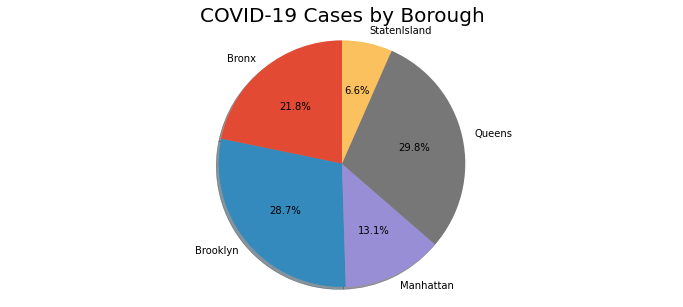

In [32]:
fig, ax = plt.subplots(figsize=(12,5))

ax.pie(test_by_boro['Case_Count'], labels=test_by_boro['Borough'], autopct='%1.1f%%',
      shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('COVID-19 Cases by Borough', fontsize=20)
plt.savefig('../img/Pie_Chart_by_Boro', dpi=80)

In [33]:
test_by_day

,Date,Total_Tests,Positive_Tests,Percent_Positive,Total_Tests_7Days_AVG,Positive_Tests_7Days_AVG,Percent_Positive_7Days_AVG,Incomplete,Cum_Positive_Tests,Cum_Total_Tests,Cum_Percent_Positive
0,2020-03-03,14,1,0.0714,NaN,NaN,NaN,NaN,1,14,0.071429
1,2020-03-04,33,5,0.1515,NaN,NaN,NaN,NaN,6,47,0.127660
2,2020-03-05,65,4,0.0615,NaN,NaN,NaN,NaN,10,112,0.089286
3,2020-03-06,85,8,0.0941,NaN,NaN,NaN,NaN,18,197,0.091371
4,2020-03-07,72,8,0.1111,NaN,NaN,NaN,NaN,26,269,0.096654
...,...,...,...,...,...,...,...,...,...,...,...
207,2020-09-26,19336,337,0.0174,34221.0,500.0,0.015,NaN,286908,4343707,0.066051
208,2020-09-27,14620,460,0.0315,34516.0,537.0,0.016,NaN,287368,4358327,0.065935
209,2020-09-28,43851,541,0.0123,34591.0,521.0,0.015,NaN,287909,4402178,0.065401
210,2020-09-29,42695,816,0.0191,34849.0,566.0,0.016,NaN,288725,4444873,0.064957


In [34]:
#sum_per_date_2020['week_avg_2020'] = sum_per_date_2020.iloc[:,2].rolling(window=7).mean()


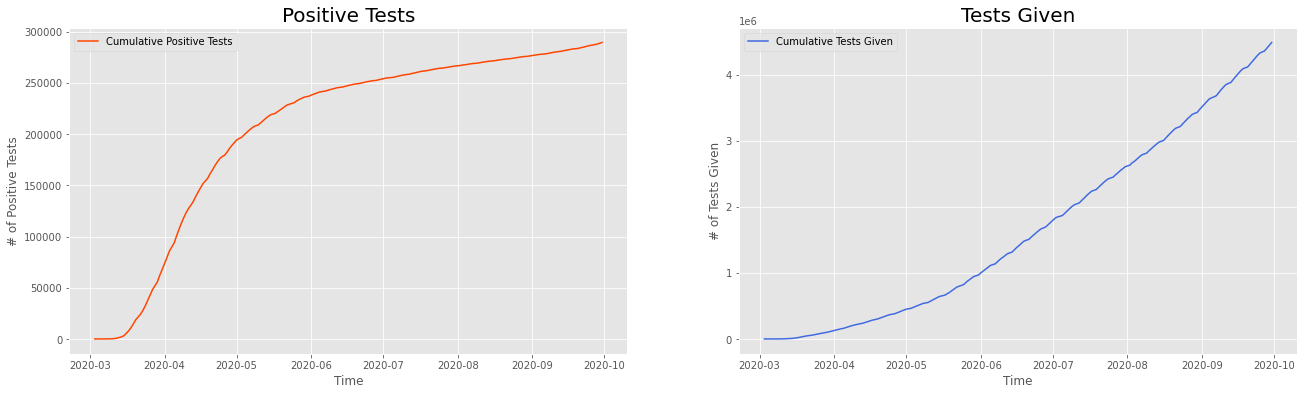

In [35]:
fig, ax = plt.subplots(1, 2,figsize=(22, 6))

ax[0].plot(test_by_day['Date'], test_by_day['Cum_Positive_Tests'], color='orangered', label = 'Cumulative Positive Tests')
ax[1].plot(tests_by_day['Date'], test_by_day['Cum_Total_Tests'], color='royalblue', label = 'Cumulative Tests Given')


ax[0].set_title('Positive Tests', fontsize=20)
ax[0].set_ylabel('# of Positive Tests')
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].set_title('Tests Given', fontsize=20)
ax[1].set_ylabel('# of Tests Given')
ax[1].set_xlabel('Time')
ax[1].legend()


plt.savefig('../img/Cumulative_Tests', dpi=300)

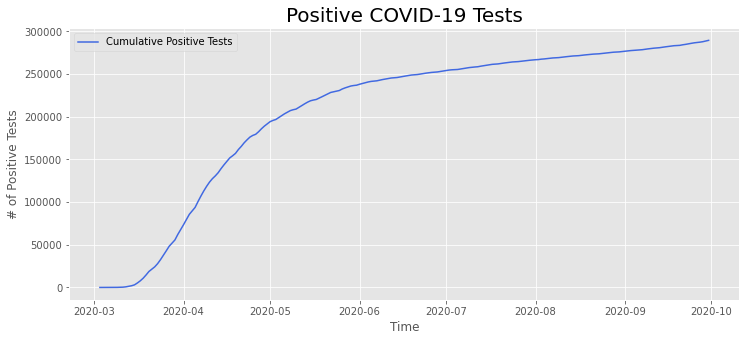

In [36]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(test_by_day['Date'], test_by_day['Cum_Positive_Tests'], color='royalblue', label = 'Cumulative Positive Tests')
#ax.plot(test_by_day['Date'], test_by_day['Cum_Total_Tests'], color='crimson', label = 'Cumulative Total Tests')
#ax.plot(test_by_day['Date'], test_by_day['Cum_Positive_Tests'], color='royalblue', label = 'Cumulative Positive Tests')
#ax.plot(test_by_day['Date'], test_by_day['Cum_Total_Tests'], color='firebrick', label = 'Cumulative Total Tests')

ax.set_title('Positive COVID-19 Tests', fontsize=20)
ax.set_ylabel('# of Positive Tests')
ax.set_xlabel('Time')
ax.legend()

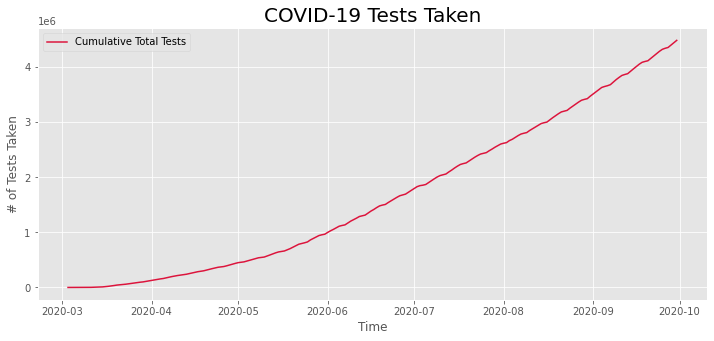

In [37]:
fig, ax = plt.subplots(figsize=(12,5))

#ax.plot(test_by_day['Date'], test_by_day['Cum_Positive_Tests'], color='royalblue', label = 'Cumulative Positive Tests')
ax.plot(test_by_day['Date'], test_by_day['Cum_Total_Tests'], color='crimson', label = 'Cumulative Total Tests')
#ax.plot(test_by_day['Date'], test_by_day['Cum_Positive_Tests'], color='royalblue', label = 'Cumulative Positive Tests')
#ax.plot(test_by_day['Date'], test_by_day['Cum_Total_Tests'], color='firebrick', label = 'Cumulative Total Tests')

ax.set_title('COVID-19 Tests Taken', fontsize=20)
ax.set_ylabel('# of Tests Taken')
ax.set_xlabel('Time')
ax.legend()

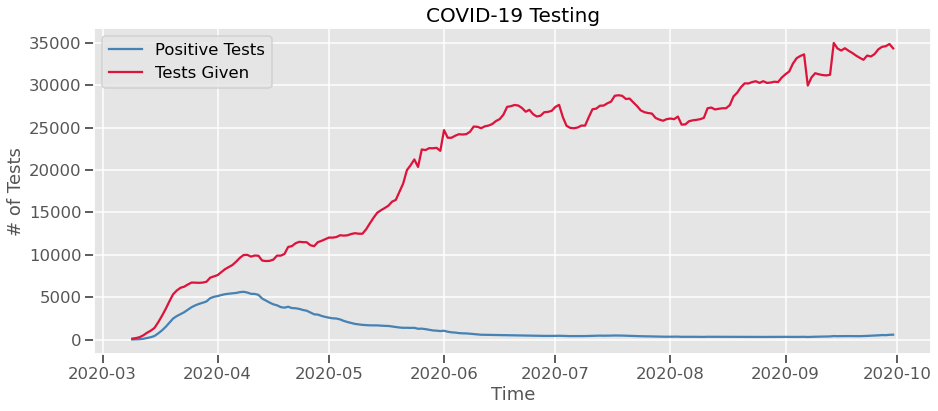

In [41]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(test_by_day['Date'], test_by_day['Positive_Tests_7Days_AVG'], color='steelblue', label = 'Positive Tests')
ax.plot(test_by_day['Date'], test_by_day['Total_Tests_7Days_AVG'], color='crimson', label = 'Tests Given')
#ax.plot(test_by_day['Date'], test_by_day['Cum_Positive_Tests'], color='royalblue', label = 'Cumulative Positive Tests')
#ax.plot(test_by_day['Date'], test_by_day['Cum_Total_Tests'], color='firebrick', label = 'Cumulative Total Tests')

ax.set_title('COVID-19 Testing', fontsize=20)
ax.set_ylabel('# of Tests')
ax.set_xlabel('Time')
ax.legend()
plt.savefig('../img/covid_testing', dpi=200)

In [39]:
tests_by_boro = tests_by_boro.drop(5)

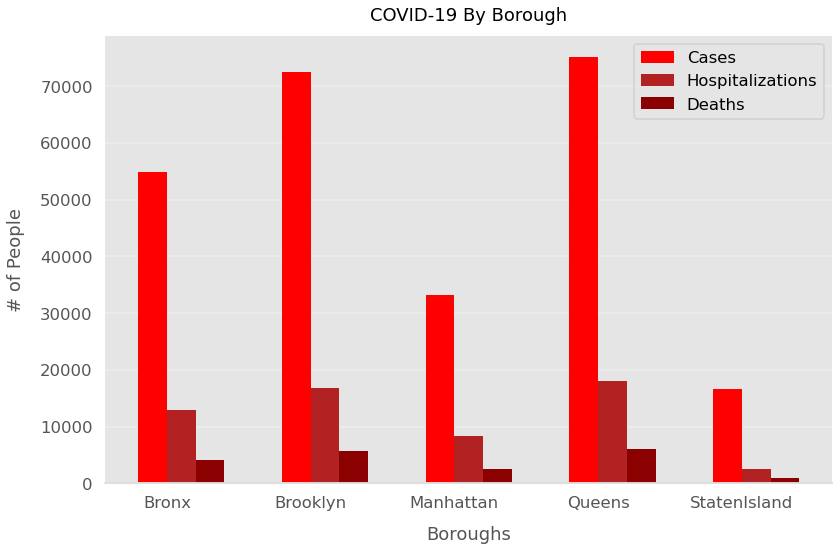

In [40]:
# Use Seaborn's context settings to make fonts larger.
import seaborn as sns
sns.set_context('talk')

# Create a grouped bar chart, with job as the x-axis
# and gender as the variable we're grouping on so there
# are two bars per job.
fig, ax = plt.subplots(figsize=(12, 8))

# Our x-axis. We basically just want a list
# of numbers from zero with a value for each
# of our jobs.
x = np.arange(len(tests_by_boro))

# Define bar width. We need this to offset the second bar.
bar_width = 0.2

b1 = ax.bar(x, tests_by_boro['Case_Count'],
            width=bar_width, color='red', label='Cases')
# Same thing, but offset the x.
b2 = ax.bar(x + bar_width, tests_by_boro['Hospitalized_Count'],
            width=bar_width, color="firebrick", label='Hospitalizations')

b3 = ax.bar(x + (bar_width*2), tests_by_boro['Death_Count'],
            width=bar_width, color="darkred", label='Deaths')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(tests_by_boro['Borough'])

# Add legend.
ax.legend()

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Boroughs', labelpad=15)
ax.set_ylabel('# of People', labelpad=15)
ax.set_title('COVID-19 By Borough', pad=15)

fig.tight_layout()

plt.savefig('../img/covid_by_boro', dpi=300)